In [11]:
# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Inspect Dataset

In [80]:
df = pd.read_csv('./SolarPrediction.csv')

In [68]:
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [38]:
df.shape

(32686, 11)

In [7]:
df.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

# Exploratory Data Analysis (EDA)

## Feature Correlation

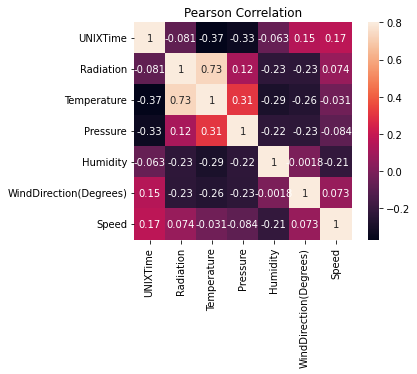

<Figure size 864x648 with 0 Axes>

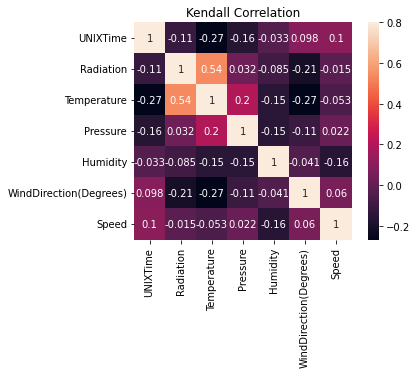

<Figure size 864x648 with 0 Axes>

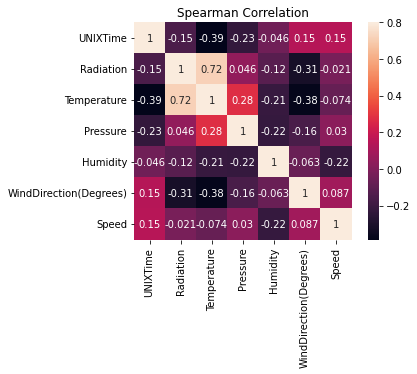

<Figure size 864x648 with 0 Axes>

In [12]:
for method in ['pearson', 'kendall', 'spearman']:
    # Correlation matrix
    corrmat = df.corr(method=method)

    # Plot the heatmap of a correlation matrix
    ax = plt.axes()
    fig = plt.figure(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, ax=ax, square=True, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()

As we can see, the main features here that correlate with `Radiation` are:
- `Temperature`
- `Humidity`
- `Wind Direction`

But here, we didn't take advantage of `TimeSunRise` and `TimeSunSet` features. So we might want take those into account.

Now we can look at how features correlate between themselves to try to create a feature that will utilize that information.

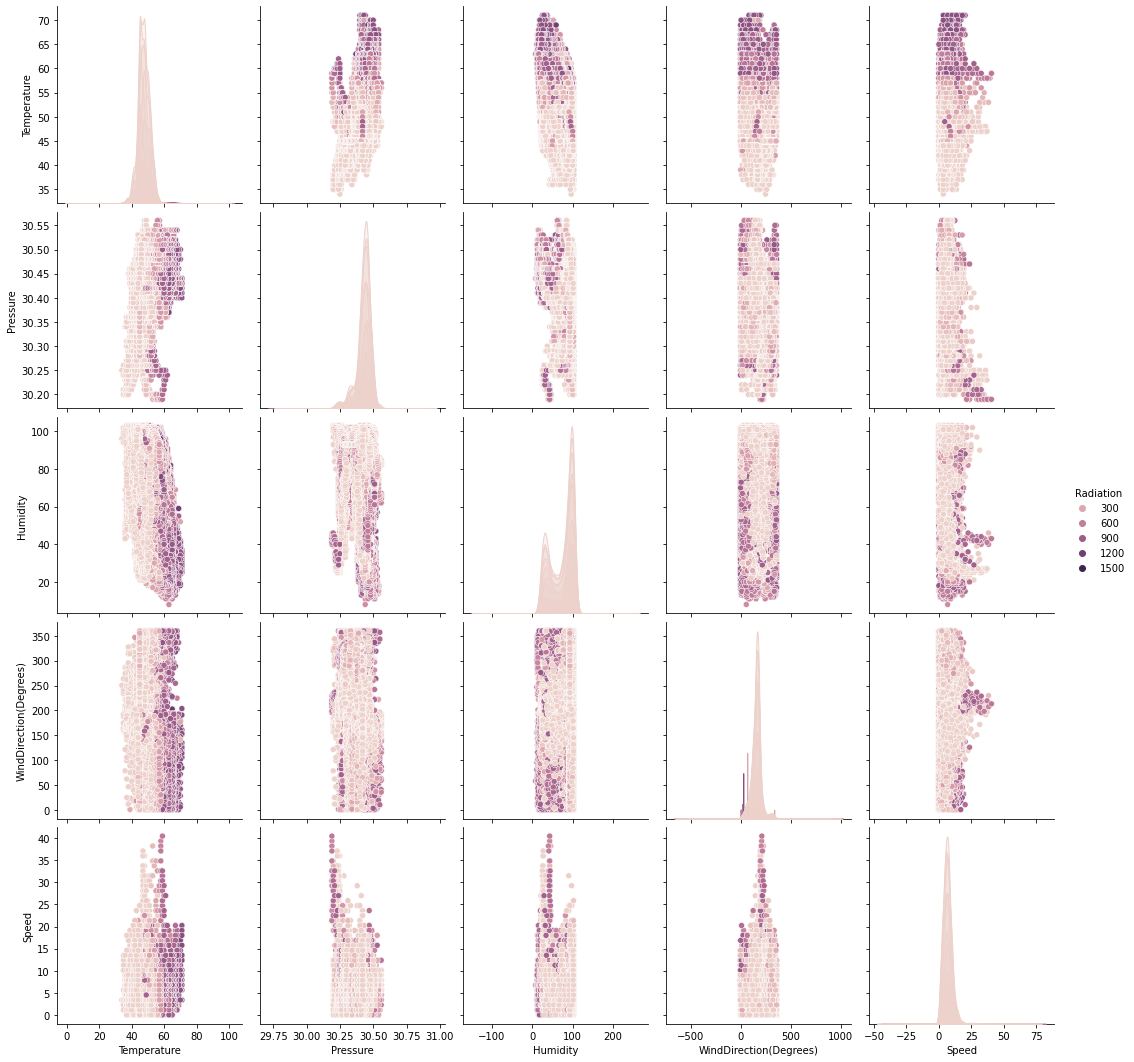

In [34]:
# Include only the columns that have sufficient correlation with the 'Outcome'.
cols = ["Temperature", "Pressure", "Humidity", "WindDirection(Degrees)", "Speed", "Radiation"]
# Plot the relationship between all features using 'Outcome' as a visual metric.
sns.pairplot(df[cols], height=3.0, hue="Radiation")

As we can see, there is not really much we can do to separate the samples just because we have the records taken during day and night time, which is alright when we are doing the forecasting.

## Feature Engineering
Given `TimeSunRise` and `TimeSunSet` features, we can try take advantage of them by calculating the approximate sun position deviation from zenith. We are interested in this because sun emits the most amount of radiation when being in zenith.

In [69]:
def to_timedelta(time_str):
    """
    Convert string formatted time to timedelta.

    :param time_str: str - Time in format "HH:MM:SS".
    :return: timedelta
    """
    time = time_str.split(":")
    return timedelta(hours=int(time[0]), minutes=int(time[1]))


def current_zenith_deviation(row):
    """
    Given sunrise and sunset time, calculate approximate zenith time and
    subtract it from the current time to get approximate zenith deviation time.

    :param row: list - Row(TimeSunRise, TimeSunSet, Time)
    :return: float - Zenith deviation in minutes.
    """
    sunrise_time, sunset_time, current_time = row[0], row[1], row[2]
    
    # Convert to timedelta.
    sunrise_td, sunset_td = to_timedelta(sunrise_time), to_timedelta(sunset_time)
    current_td = to_timedelta(current_time)

    # Get approximate sun zenith time.
    approximate_zenith_td = sunrise_td + (sunset_td - sunrise_td) / 2

    # Get current time deviation from time the sun is in zenith.
    if approximate_zenith_td > current_td:
        zenith_time_deviation = approximate_zenith_td - current_td
    else:
        zenith_time_deviation = current_td - approximate_zenith_td

    # Return zenith deviation in minutes.
    return zenith_time_deviation.total_seconds() // 60

In [81]:
df["ZenithDeviation"] = df[["TimeSunRise", 	"TimeSunSet", "Time"]].apply(current_zenith_deviation,  axis=1)

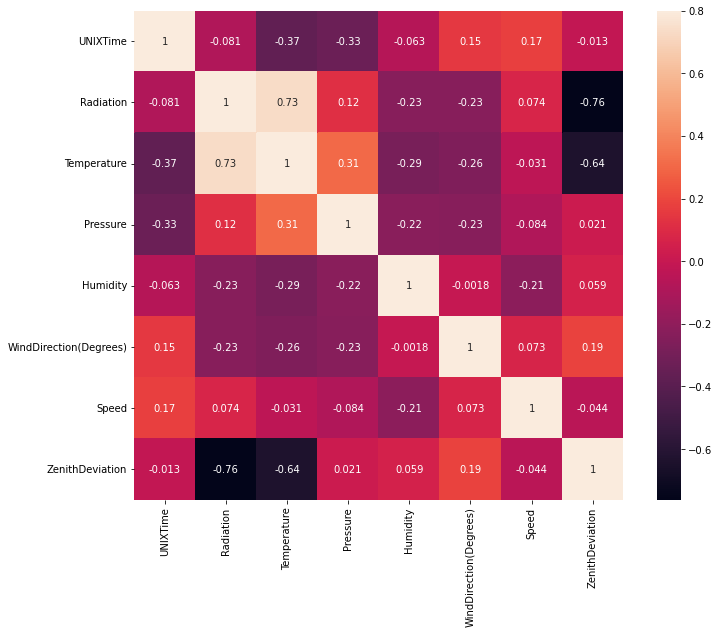

In [71]:
# Correlation matrix
corrmat = df.corr()

# Plot the heatmap of a correlation matrix
fig = plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
plt.show()

As we can see, `Zenith Deviation` has now the biggest correlation with `Radiation` and `Temperature`.

Apart from that, we also want to add some time features for the future forecasting.

In [82]:
df["DateTime"] = pd.to_datetime(df['UNIXTime'], unit='s') - timedelta(hours=10)

In [83]:
df['Year'] = df.DateTime.dt.year
df['Month'] = df.DateTime.dt.month
df['Day'] = df.DateTime.dt.day
df['Hour'] = df.DateTime.dt.hour

In [84]:
df['HourlyDateTime'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=df.Day, hour=df.Hour))
df['DailyDateTime'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=df.Day))

df.index = df['HourlyDateTime']

Make sure our timeseries is continuous.

In [85]:
df = df[(df['HourlyDateTime'] > datetime(2016, 10, 1, 0)) & (df['HourlyDateTime'] < datetime(2016, 11, 29, 0))]
df = df.sort_index(ascending=True)

In [90]:
# Drop now unnecessary columns.
df = df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis=1)

## Sava Data

In [94]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,ZenithDeviation,DateTime,Year,Month,Day,Hour,HourlyDateTime,DailyDateTime
HourlyDateTime,,,,,,,,,,,,,,
2016-10-01 01:00:00,1.28,51,30.44,99,148.18,6.75,637.0,2016-10-01 01:35:24,2016,10,1,1,2016-10-01 01:00:00,2016-10-01
2016-10-01 01:00:00,1.24,49,30.45,97,146.72,11.25,672.0,2016-10-01 01:00:25,2016,10,1,1,2016-10-01 01:00:00,2016-10-01
2016-10-01 01:00:00,1.29,50,30.45,98,178.42,9.00,667.0,2016-10-01 01:05:20,2016,10,1,1,2016-10-01 01:00:00,2016-10-01
2016-10-01 01:00:00,1.26,50,30.45,98,109.41,5.62,662.0,2016-10-01 01:10:21,2016,10,1,1,2016-10-01 01:00:00,2016-10-01
2016-10-01 01:00:00,1.27,50,30.45,98,184.21,4.50,657.0,2016-10-01 01:15:25,2016,10,1,1,2016-10-01 01:00:00,2016-10-01


In [95]:
df.shape

(16867, 14)

In [96]:
df.to_csv("./SolarRadiationProcessed.csv", sep=",", columns=df.columns, float_format="%.2f")